In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datasets import load_dataset
import pandas as pd
import math
import scipy
from scipy.stats import wasserstein_distance
from scipy import stats

import networkx as nx
from networkx.drawing.nx_pydot import to_pydot
import pydot
from IPython.display import Image, display

In [2]:
planning_color = "#ef9d65"
implement_color = "#84bcd1"
revision_color = "#9584d1"

planning_classes = ["Idea Generation", 'Idea Organization', 'Section Planning']
implement_classes = ['Text Production', 'Object Insertion', 'Cross-reference', 'Citation Integration', 'Macro Insertion']
revision_classes = ['Fluency','Coherence', 'Clarity', 'Structural', "Linguistic Style", 'Scientific Accuracy', 'Visual Formatting']
all_class = planning_classes + implement_classes + revision_classes

def color_picker(label):
  if (label in planning_classes):
    return planning_color
  elif (label in implement_classes):
    return implement_color
  elif (label in revision_classes):
    return revision_color
  else:
    return other_color

In [3]:
dataset = load_dataset("minnesotanlp/scholawrite")
df = pd.DataFrame(dataset["all_sorted"])
print(df["label"].value_counts())

label
Text Production         35323
Clarity                  7096
Idea Generation          4325
Object Insertion         2814
Structural               2269
Coherence                2004
Visual Formatting        1952
Section Planning         1324
Cross-reference          1016
Linguistic Style          962
Fluency                   863
Citation Integration      667
Scientific Accuracy       443
Idea Organization         310
Macro Insertion           136
Name: count, dtype: int64


In [4]:
result = df.project.value_counts()
result = result.reindex([1,2,3,4,5])
print(result)

project
1    14217
2     5059
3     6641
4     8348
5    27239
Name: count, dtype: int64


In [5]:
# global variable to make sure resuts are in the same order
all_project = df["project"].unique()

# Table 3

In [6]:
for pid in all_project:
    print("project ", pid)
    counts = df[df["project"]==pid]["label"].value_counts()
    counts = counts.reindex(all_class)
    print(counts)

project  1
label
Idea Generation          515.0
Idea Organization          NaN
Section Planning         182.0
Text Production         9267.0
Object Insertion         583.0
Cross-reference          141.0
Citation Integration      75.0
Macro Insertion           16.0
Fluency                  116.0
Coherence                422.0
Clarity                 1249.0
Structural               359.0
Linguistic Style         233.0
Scientific Accuracy      307.0
Visual Formatting        752.0
Name: count, dtype: float64
project  2
label
Idea Generation          130
Idea Organization         45
Section Planning          57
Text Production         2438
Object Insertion         383
Cross-reference          112
Citation Integration     151
Macro Insertion            7
Fluency                   90
Coherence                242
Clarity                  645
Structural               506
Linguistic Style          75
Scientific Accuracy       15
Visual Formatting        163
Name: count, dtype: int64
project  3
l

# Table 2

In [7]:
import warnings
warnings.filterwarnings('ignore')

def word_count(text):
  if (type(text) is not str):
    return 0
  return len(text.split()) # naive way of counting words / complexity of latex text

def count_project_words(df, project_id):
  df_local = df[df["project"]==project_id]

  df_local.sort_values(by="timestamp")
  df_local["after_word_count"] = df_local["after text"].apply(word_count)
  df_local["before_word_count"] = df_local["before text"].apply(word_count)
  df_local.loc[:, "diff"] = df_local["after_word_count"]  - df_local["before_word_count"]

  added = df_local[df_local["diff"] > 0]["diff"].sum()
  deleted = -df_local[df_local["diff"] < 0]["diff"].sum()

  print("project_id:", project_id, "words added:", added, "words deleted:", deleted)

for i in all_project:
  count_project_words(df, i)

project_id: 1 words added: 17387 words deleted: 11739
project_id: 2 words added: 23835 words deleted: 15158
project_id: 3 words added: 7779 words deleted: 2308
project_id: 4 words added: 12448 words deleted: 7621
project_id: 5 words added: 57511 words deleted: 25853


# figure 5

## (a) distribution (log) of intentions

<BarContainer object of 15 artists>

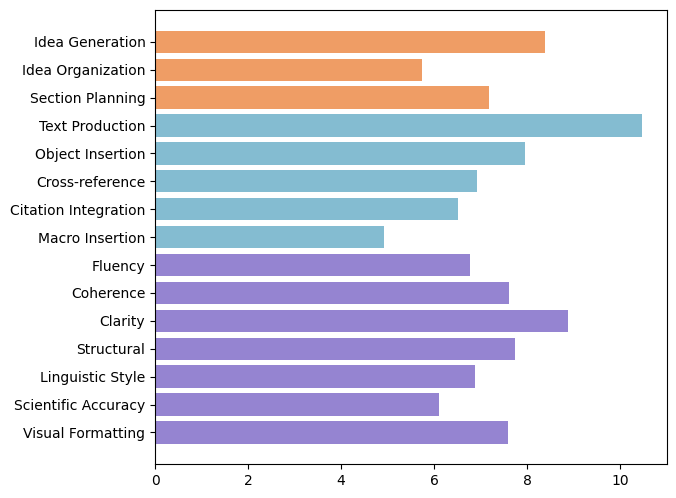

In [8]:
# log freq graph

expected_order = planning_classes + implement_classes + revision_classes
expected_order.reverse()
log_freqs = df.label.value_counts().apply(np.log)
log_freqs = log_freqs.reindex(expected_order)
colors = [color_picker(label) for label in log_freqs.index]
plt.figure(figsize=(6.6, 5.9))
plt.barh(log_freqs.index.astype(str), log_freqs.values, color=colors)

## (b) distance to uniform distribution

In [9]:
num_windows = 10

def get_label_distr(win_num, labels):
    window_size = math.ceil(len(labels)/win_num)
    step = window_size

    distr_dict={}
    for label_class in [planning_classes, implement_classes, revision_classes]:
        for label in label_class:
            distr_dict[label] = []


    for start_idx in range(0, len(labels), step):
        window = labels[start_idx : start_idx + window_size]

        counts = pd.Series(window).value_counts()

        cd = counts.to_dict()

        for each in distr_dict:
            if each in cd:
                distr_dict[each].append(cd[each])
            else:
                distr_dict[each].append(0)
    return distr_dict



In [10]:
def calculate_label_wasserstein_distance(label_distr):
    all_label_distance = {}
    for each in label_distr:

        total = sum(label_distr[each])
        if total == 0:
            continue

        normalized_distri = [count/total for count in label_distr[each]]

        uniform_distr = [0.1] * num_windows

        if label_distr[each] == uniform_distr:
            all_label_distance[each] = 0
        
        else:
            all_label_distance[each] = stats.wasserstein_distance(
                normalized_distri, uniform_distr
            )
    
    return all_label_distance


def plot_wasserstein_distance(data):
    labels = list(data.keys())
    values = list(data.values())

    sorted_idxs = np.argsort(values)
    labels = [labels[i] for i in sorted_idxs]
    values = [values[i] for i in sorted_idxs]

    colors = [color_picker(label) for label in labels]

    plt.figure(figsize=(6.6, 5.9))
    plt.barh(labels, values, color=colors)

    plt.tight_layout() 
    plt.show()

Project  1


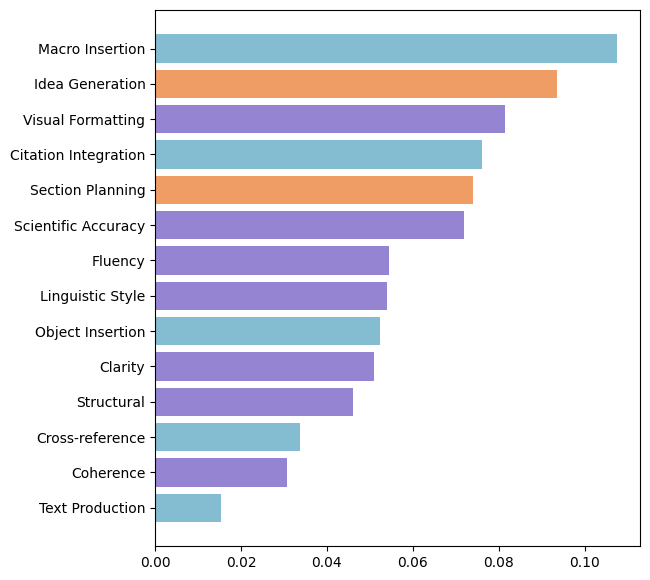

Project  2


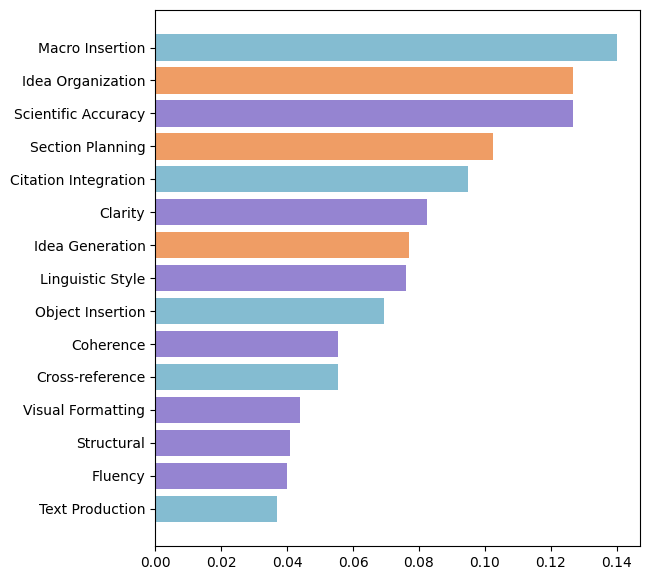

Project  3


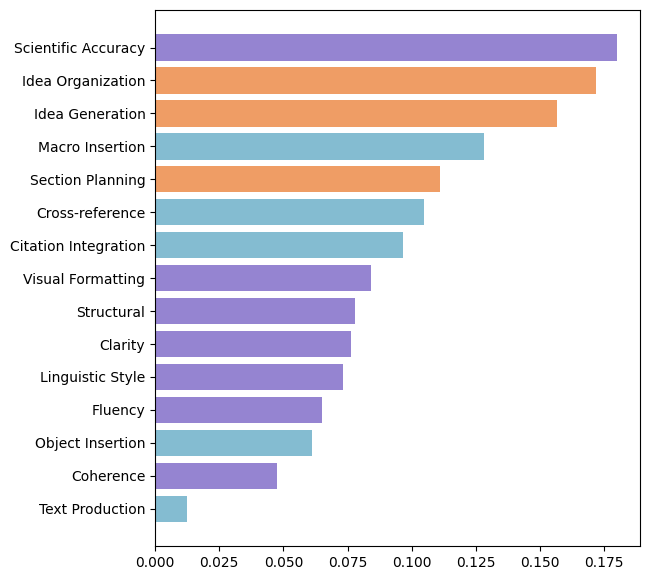

Project  4


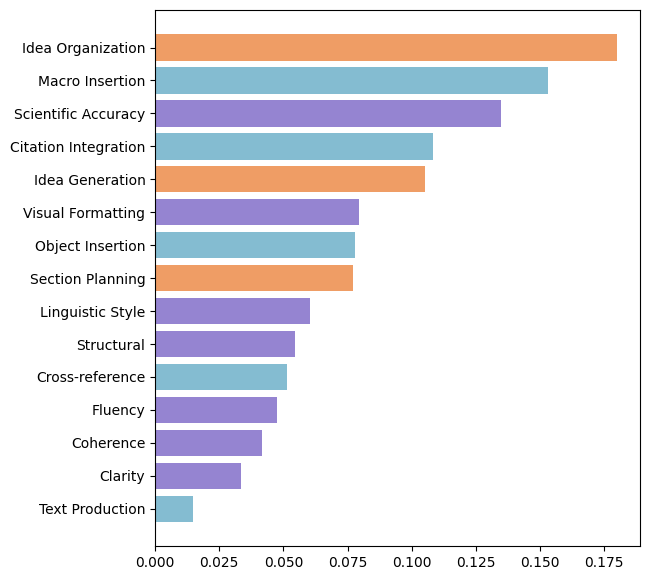

Project  5


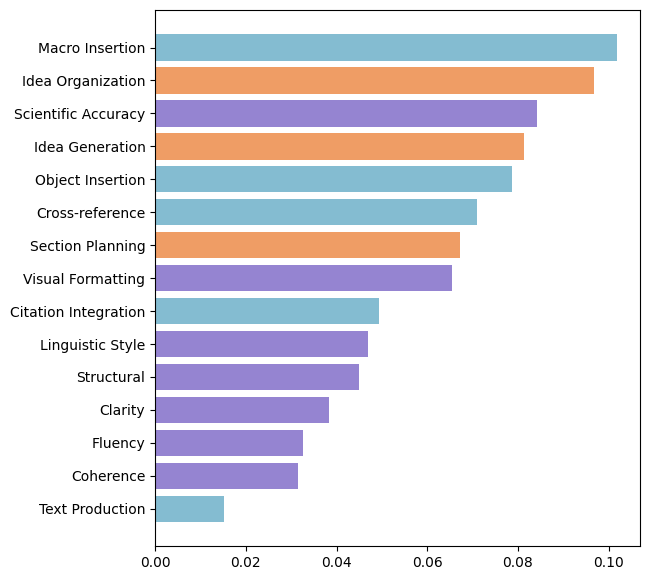

In [11]:
for pid in all_project:
    print("Project ", pid)
    labels = df[df["project"]==pid]["label"]
    distr = get_label_distr(num_windows, labels)

    all_label_distance = calculate_label_wasserstein_distance(distr)
    plot_wasserstein_distance(all_label_distance)


## (c) label distribution over time

In [12]:
def plot_distr_figure(distr_dict):

    all_arrays = []
    labels = []

    for cat in distr_dict:
        current = distr_dict[cat]
        if sum(current) == 0:
            continue

        arr = np.array(current, dtype=float)
        maxval = arr.max()
        arr_norm = arr / maxval

        all_arrays.append(arr_norm)
        labels.append(cat)
    
    
    means = []
    for cat in labels:
        current = distr_dict[cat]

        new_sum = sum(current)
        new_norm = [count/new_sum for count in current]

        weights = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
        weighted_sum = 0
        for w, e in zip(weights, new_norm):
            weighted_sum += w * e
        distri_mean = weighted_sum/10
        means.append(distri_mean)
    

    sorted_idxs = np.argsort(means)[::-1]

    all_arrays = [all_arrays[i] for i in sorted_idxs]
    labels = [labels[i] for i in sorted_idxs]

    
    fig, ax = plt.subplots(figsize=(6.6, 5.9))

    # 1.2 to leave some space between lines
    y_positions = np.arange(len(labels)) * 1.2

    # there are num_windows windows in total
    x = np.linspace(0, 1, num_windows)

    for i, arr_norm in enumerate(all_arrays):
        y_offset = y_positions[i]
        
        # add offset to make sure it show up in the correct line
        ax.plot(x, arr_norm + y_offset, 
                label=labels[i],
                color=color_picker(labels[i]),
                linewidth=1.5)
                
        # draw the shade area below each line
        ax.fill_between(x, y_offset, arr_norm + y_offset, color=color_picker(labels[i]), alpha=0.3)
        
    # +0.4 to align label with bar
    ax.set_yticks(y_positions+0.3)
    ax.set_yticklabels(labels)
    ax.tick_params(axis='y', length=0, labelsize=20)
    ax.tick_params(axis='x', labelsize=20)


    plt.tight_layout()
    plt.show()

Project 1


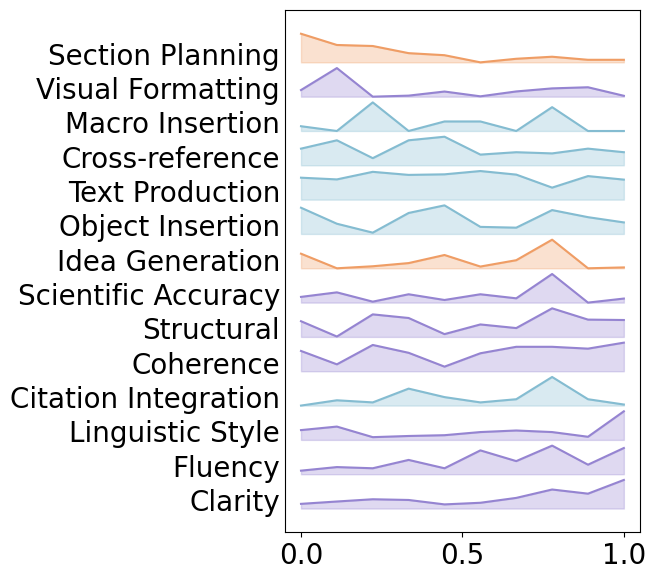

Project 2


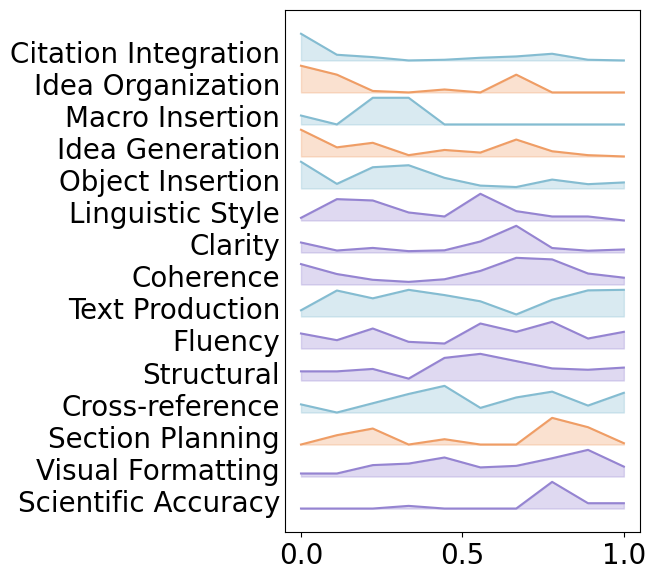

Project 3


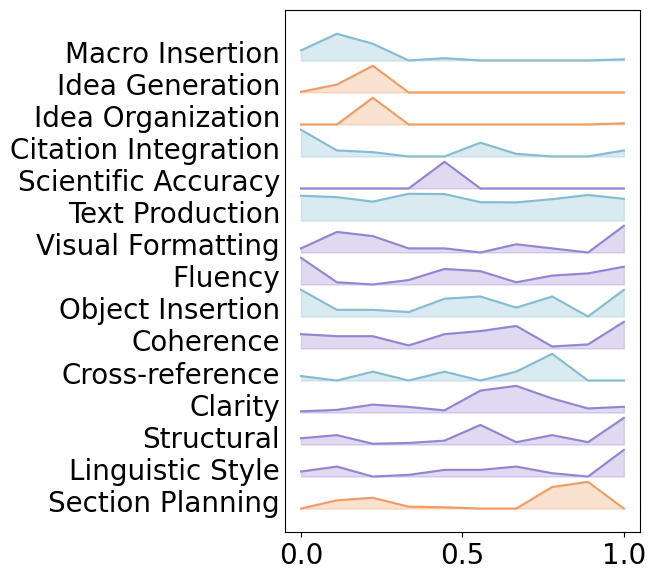

Project 4


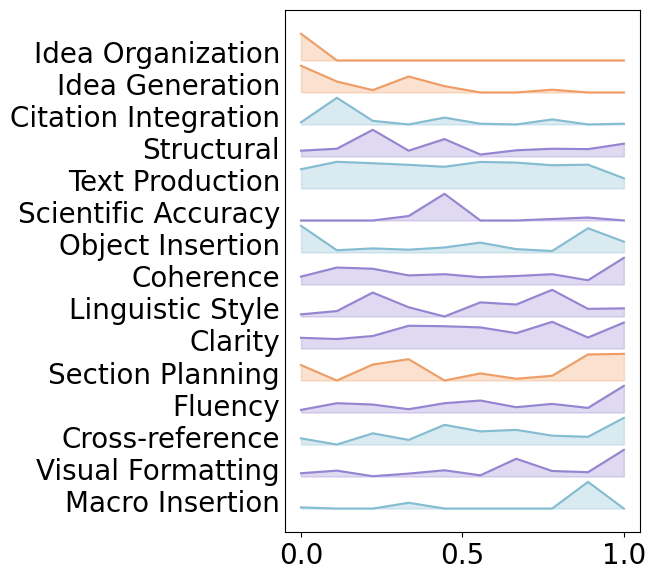

Project 5


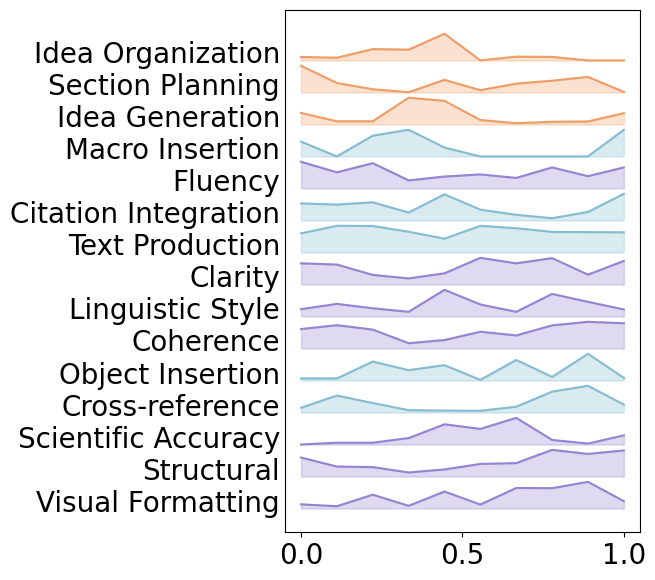

In [13]:
for pid in all_project:
    print("Project", pid)
    labels = df[df["project"]==pid]["label"]
    distr = get_label_distr(num_windows, labels)
    plot_distr_figure(distr)

# Table 4

In [14]:
expected_order = planning_classes + implement_classes + revision_classes
label_matrix= pd.DataFrame(0, index=expected_order, columns=expected_order)

for pid in all_project:
    labels = list(df[df["project"]==pid]["label"])
    for i in range(len(labels)-1):
        label_matrix.loc[labels[i], labels[i+1]] += 1

np.fill_diagonal(label_matrix.values, 0)

for label in expected_order:
    n = 1
    top_n = label_matrix.loc[label].nlargest(n).index
    for next_label in top_n:

        next_label_count = label_matrix.loc[label, next_label]
        total_label = label_matrix.loc[label].sum()
        
        probability = next_label_count / total_label

        print(f"{label} -> {next_label} ({probability:.2f})")

Idea Generation -> Text Production (0.52)
Idea Organization -> Idea Generation (0.34)
Section Planning -> Text Production (0.33)
Text Production -> Clarity (0.20)
Object Insertion -> Text Production (0.32)
Cross-reference -> Text Production (0.36)
Citation Integration -> Text Production (0.37)
Macro Insertion -> Idea Generation (0.29)
Fluency -> Text Production (0.30)
Coherence -> Text Production (0.34)
Clarity -> Text Production (0.35)
Structural -> Text Production (0.27)
Linguistic Style -> Text Production (0.29)
Scientific Accuracy -> Text Production (0.34)
Visual Formatting -> Text Production (0.25)


In [15]:
def gantt_chart(spans, durations, start_times, categories, colors, filepath):
  base_height = 1
  interval_height = 0.5 
  fig_height = len(categories) * interval_height + base_height
  fig, ax = plt.subplots(figsize=(10, fig_height))

  spans = [x for x in spans if x in categories]

  for i, color in enumerate(colors):
      ax.axhspan(len(colors) - i - 1.5, len(colors) - i - 0.5, facecolor=color, alpha=0.3)

  for i, span in enumerate(spans):
      y_position = len(categories) - categories.index(span) - 1

      ax.barh(y_position, durations[i], left=start_times[i], color='black')
  
  ax.set_yticks(np.arange(len(categories)))
  ax.set_yticklabels(reversed(categories))

  ax.set_xlabel('Step')
  ax.set_ylabel('Activity')
  ax.set_title('Writing activity per step')

  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)

  # remove vertical padding in chart
  ax.set_ylim(-0.5, len(categories) - 0.5)

  plt.tight_layout()

  if (filepath is not None):
    plt.savefig(filepath, bbox_inches="tight")
  
  plt.show()


def writing_activities_broad(labels, filepath=None):

  categories = ("Planning", "Implementation", "Revision")

  colors = [planning_color, implement_color, revision_color]

  spans = labels

  new_spans = []

  for span in spans:
    if (span in planning_classes):
      new_spans.append("Planning")
    elif (span in implement_classes):
      new_spans.append("Implementation")
    elif (span in revision_classes):
      new_spans.append("Revision")
    else:
      print("should not happen: ", span)
  
  spans = new_spans

  n_spans = len(spans)

  start_times = np.arange(n_spans)
  durations = np.ones(n_spans)
  
  gantt_chart(spans, durations, start_times, categories, colors=colors, filepath=filepath)


def writing_activities_detailed(labels, filepath=None):

  categories = all_class

  colors = [planning_color] * len(planning_classes)
  colors += [implement_color] * len(implement_classes)
  colors += [revision_color] * len(revision_classes)

  spans = labels
  spans = [x for x in spans if x in categories]

  n_spans = len(spans)

  start_times = np.arange(n_spans)
  durations = np.ones(n_spans)
  
  gantt_chart(spans, durations, start_times, categories, colors=colors, filepath=filepath)

Project  1


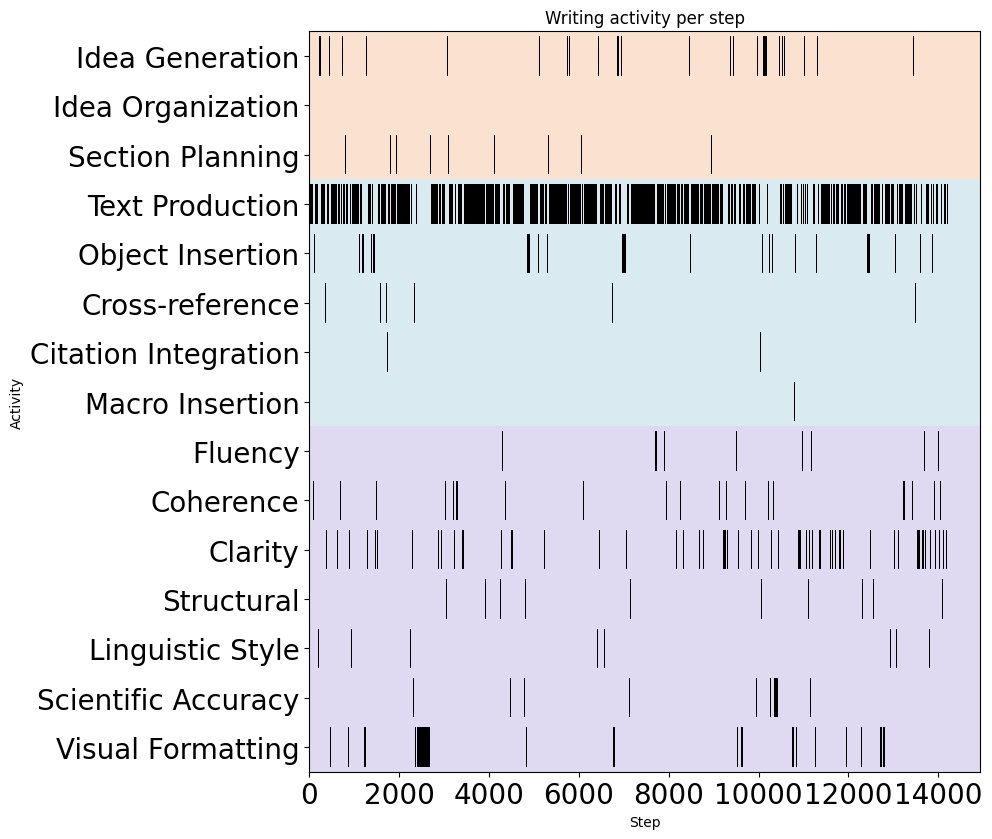

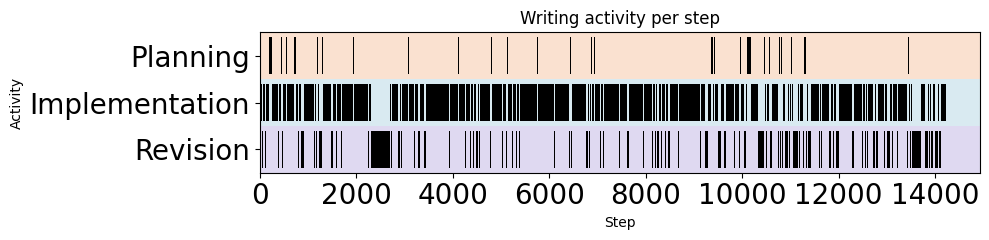

Project  2


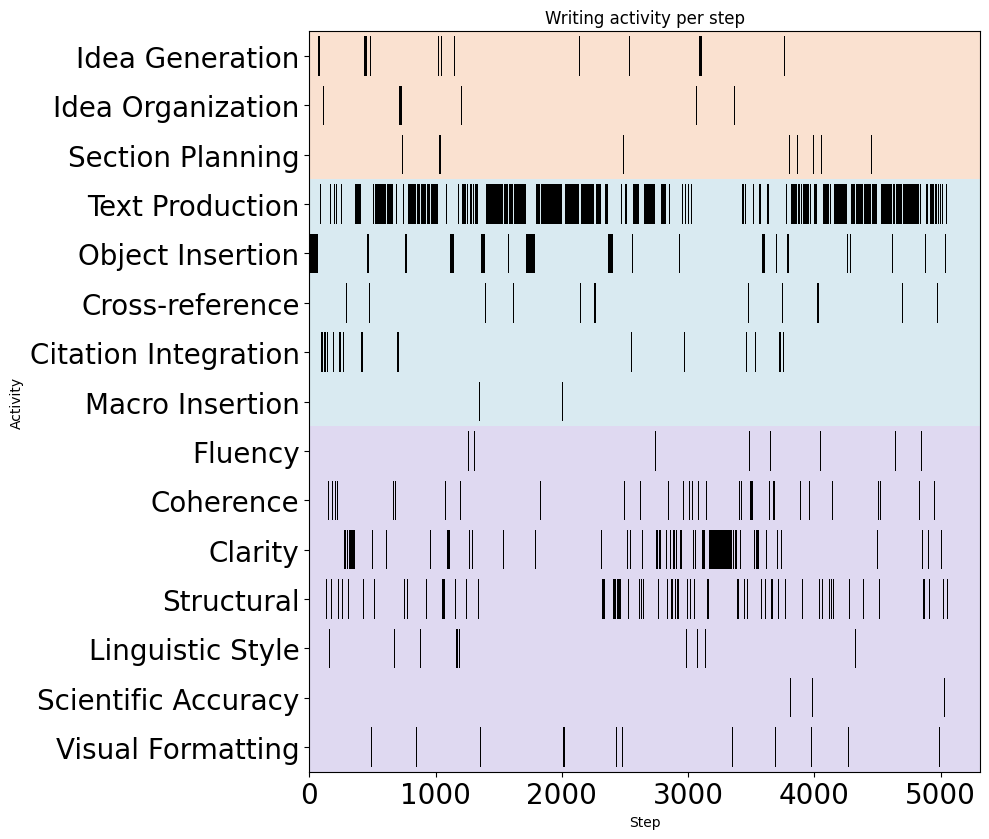

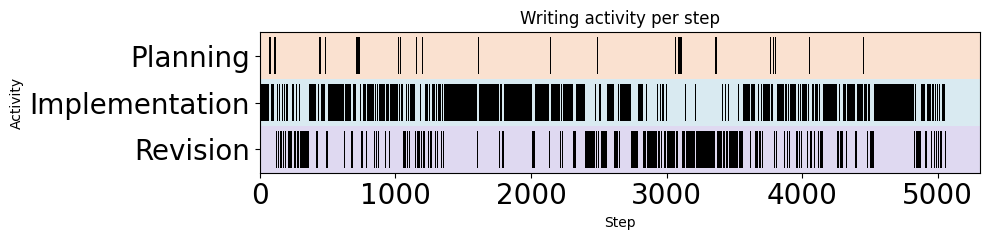

Project  3


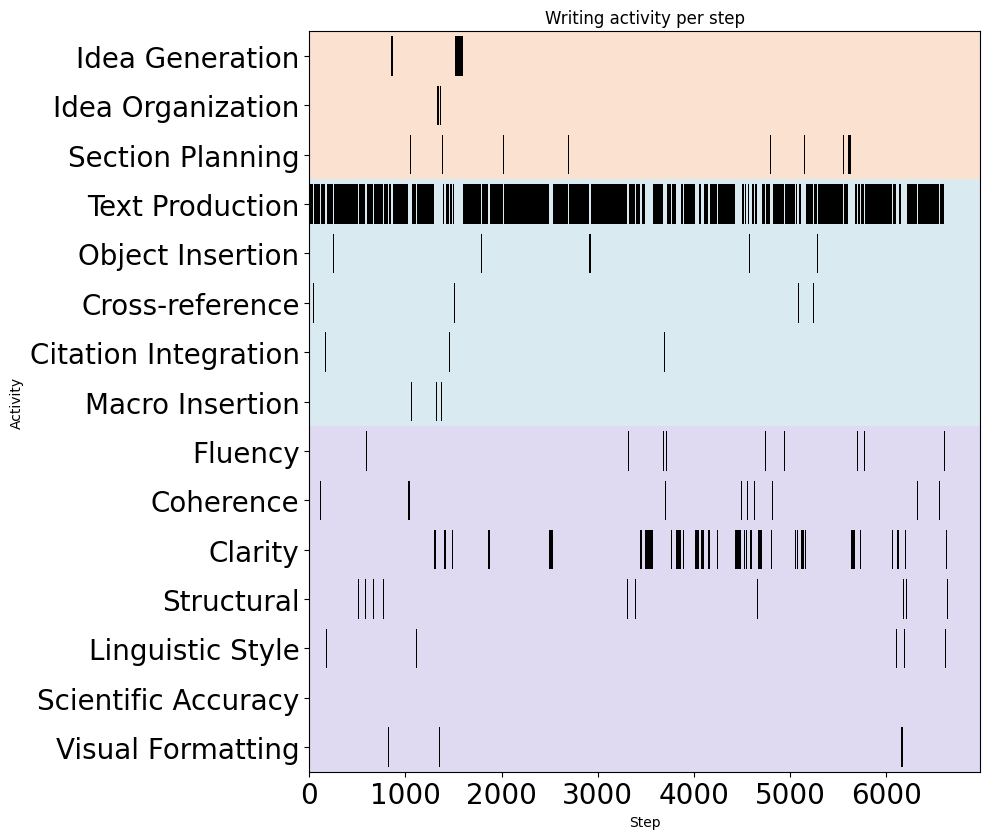

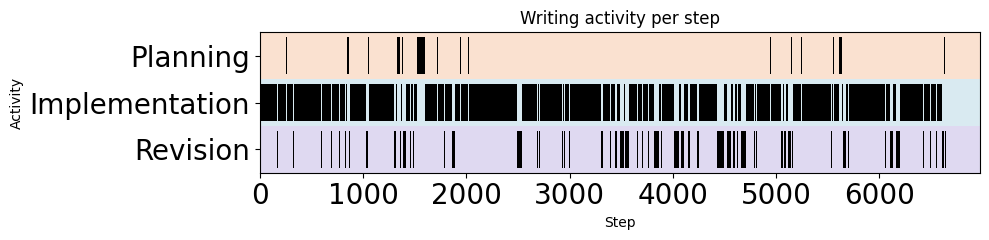

Project  4


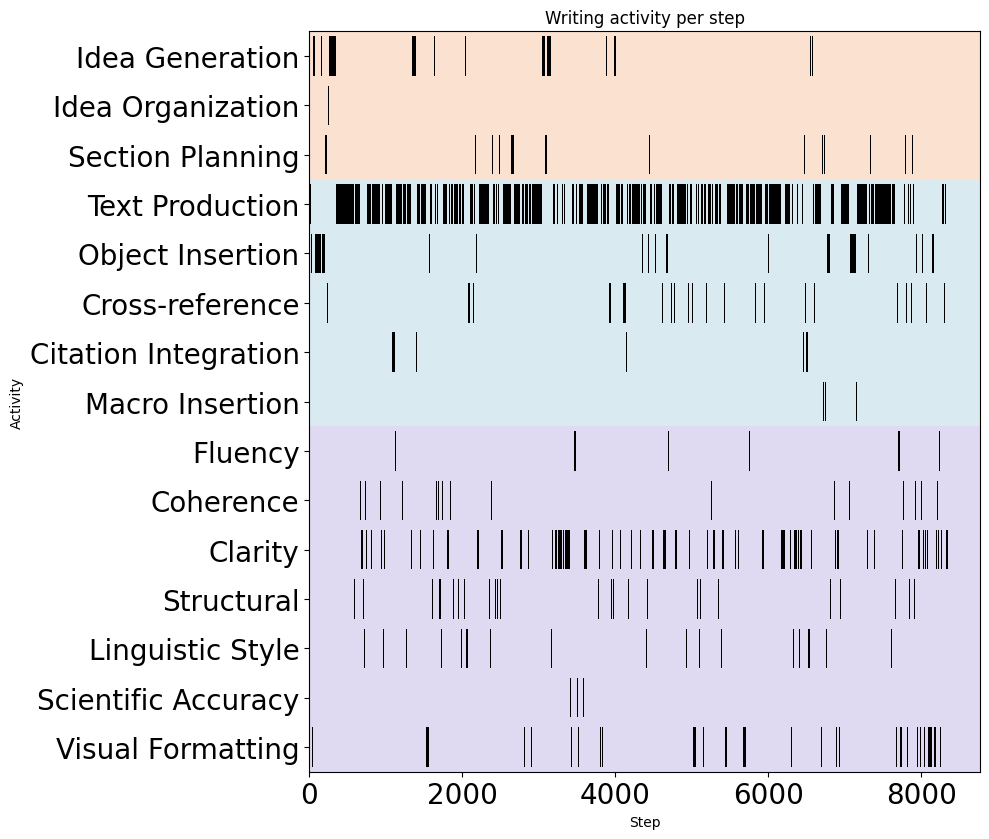

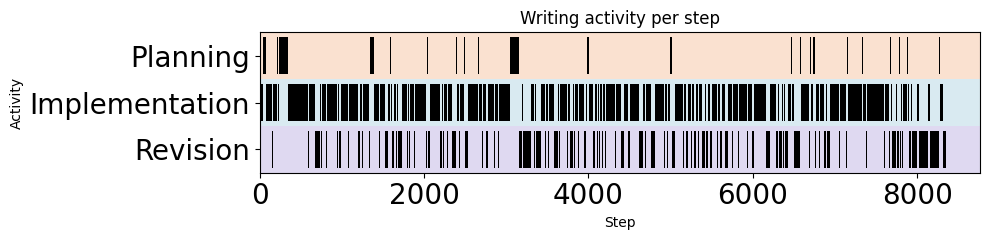

Project  5


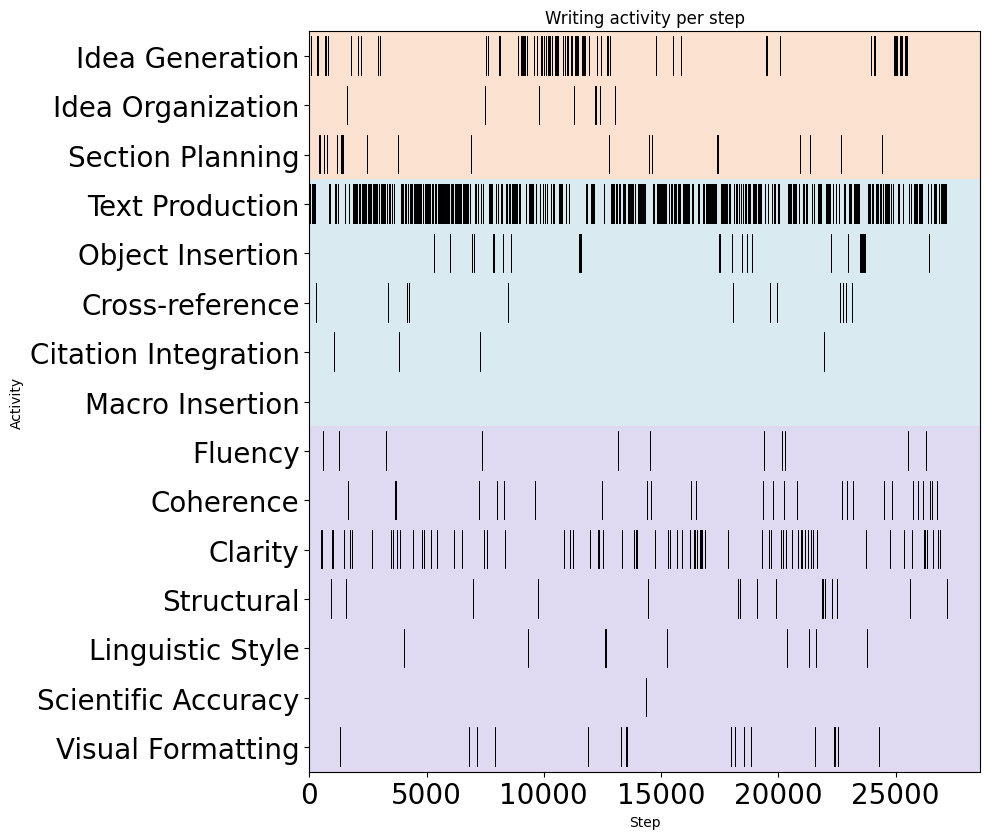

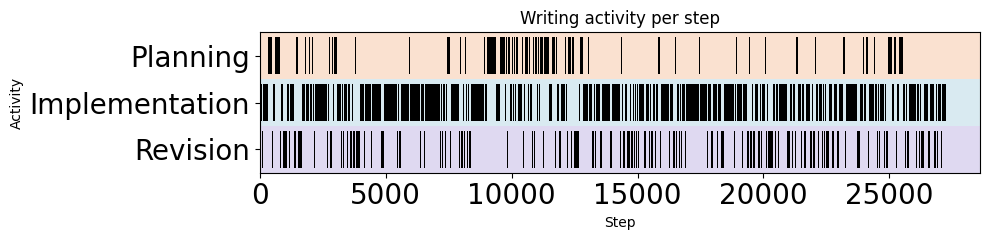

In [16]:
for pid in all_project:
    print("Project ", pid)
    labels = df[df["project"]==pid]["label"]
    writing_activities_detailed(labels, f"project{pid}_detailed.pdf")
    writing_activities_broad(labels, f"project{pid}_broad.pdf")

gpt4o_output seed1


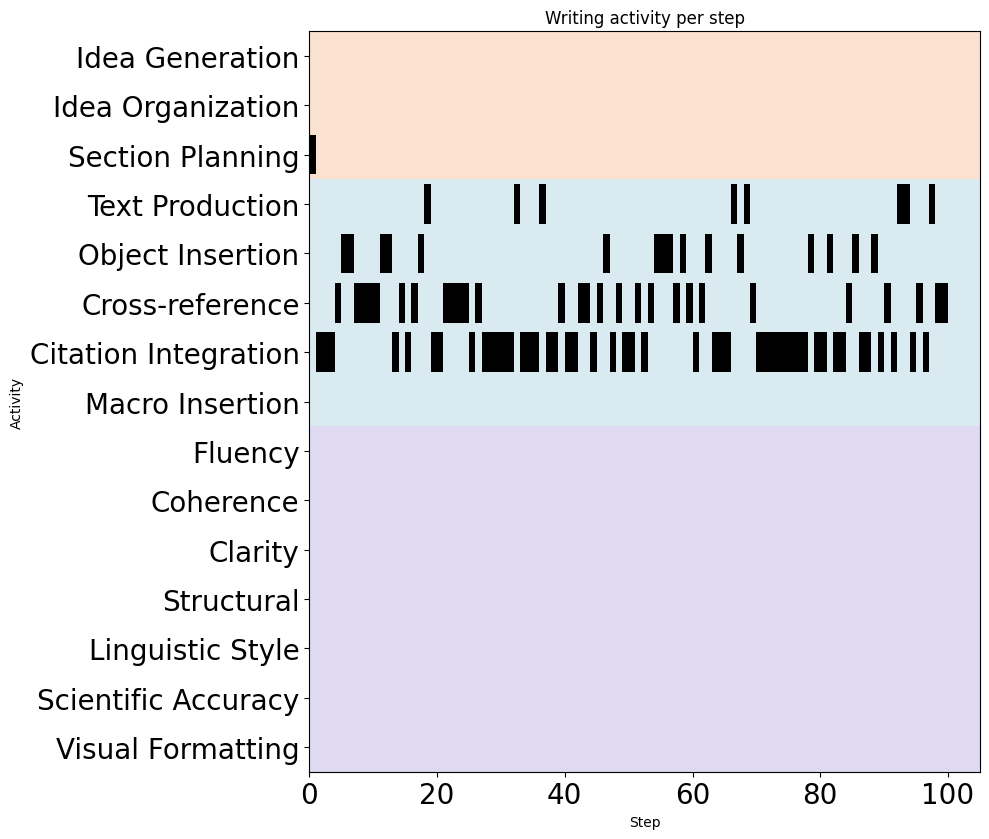

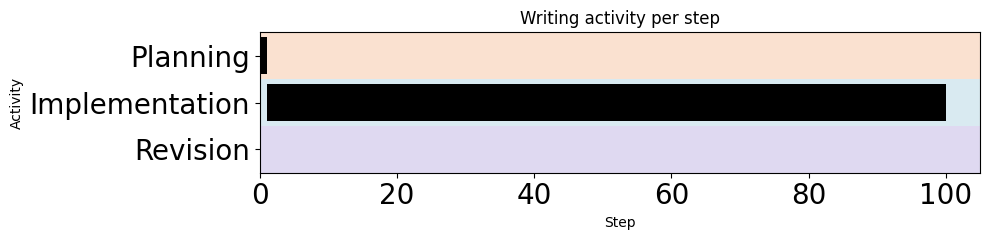

gpt4o_output seed2


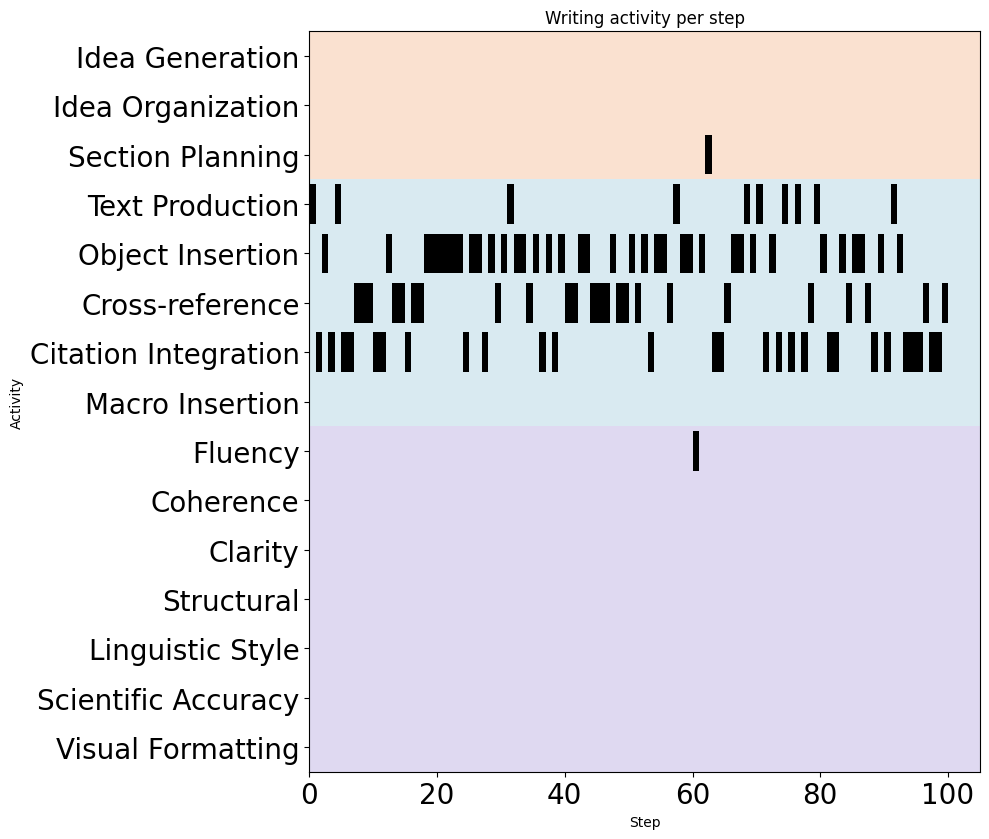

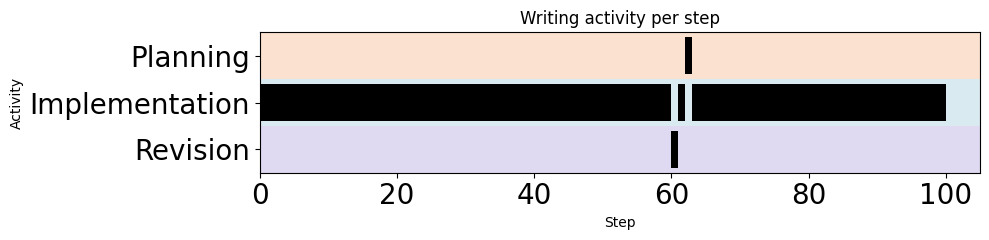

gpt4o_output seed3


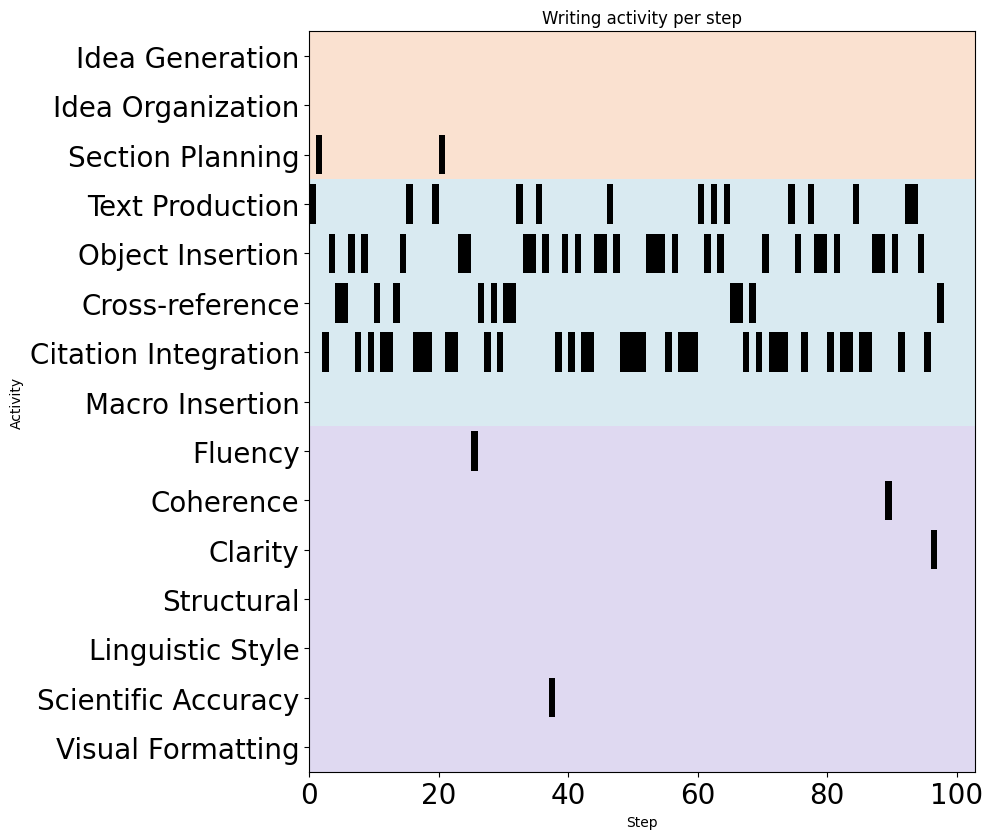

should not happen:  Author Insertion
should not happen:  \author{}


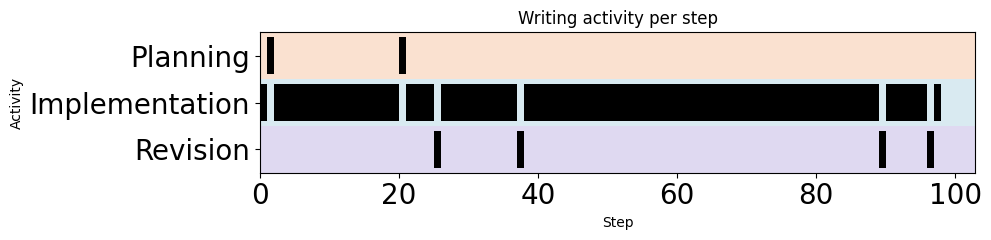

gpt4o_output seed4


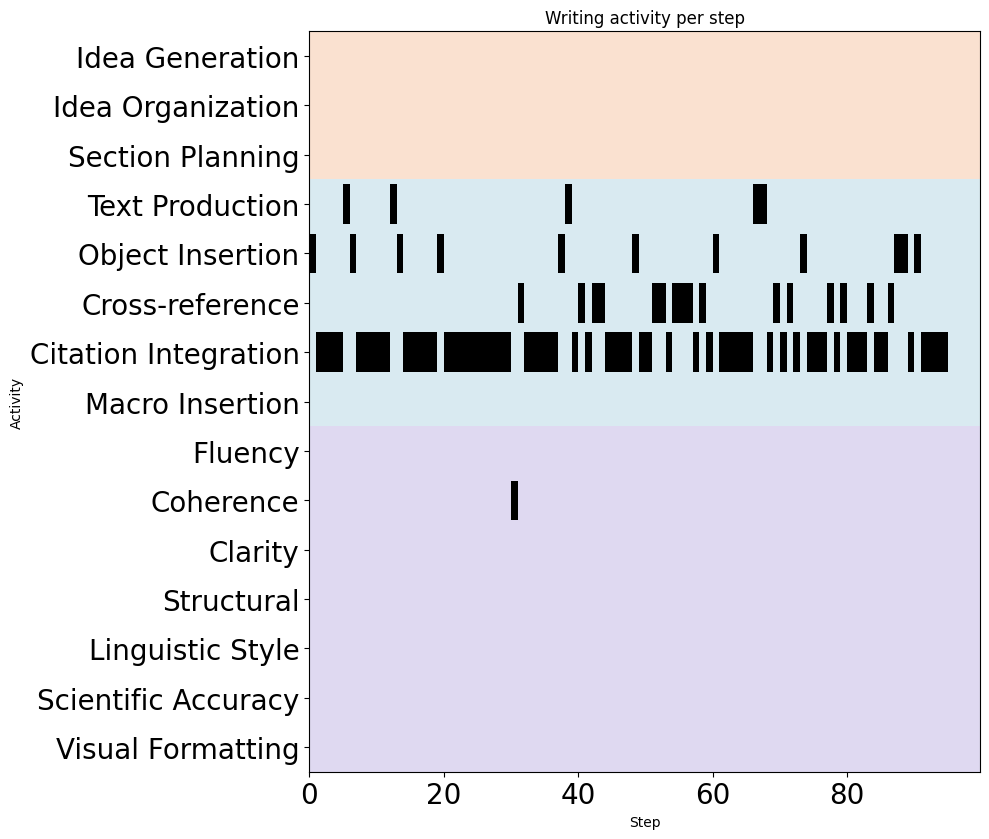

should not happen:  Author
should not happen:  Author
should not happen:  Author Integration
should not happen:  Author Integration
should not happen:  Author Integration


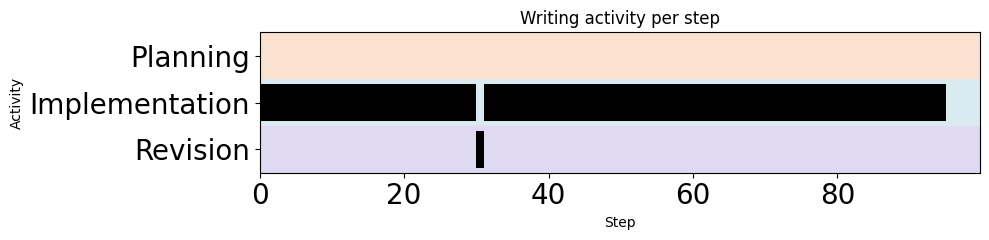

llama8_meta_output seed1


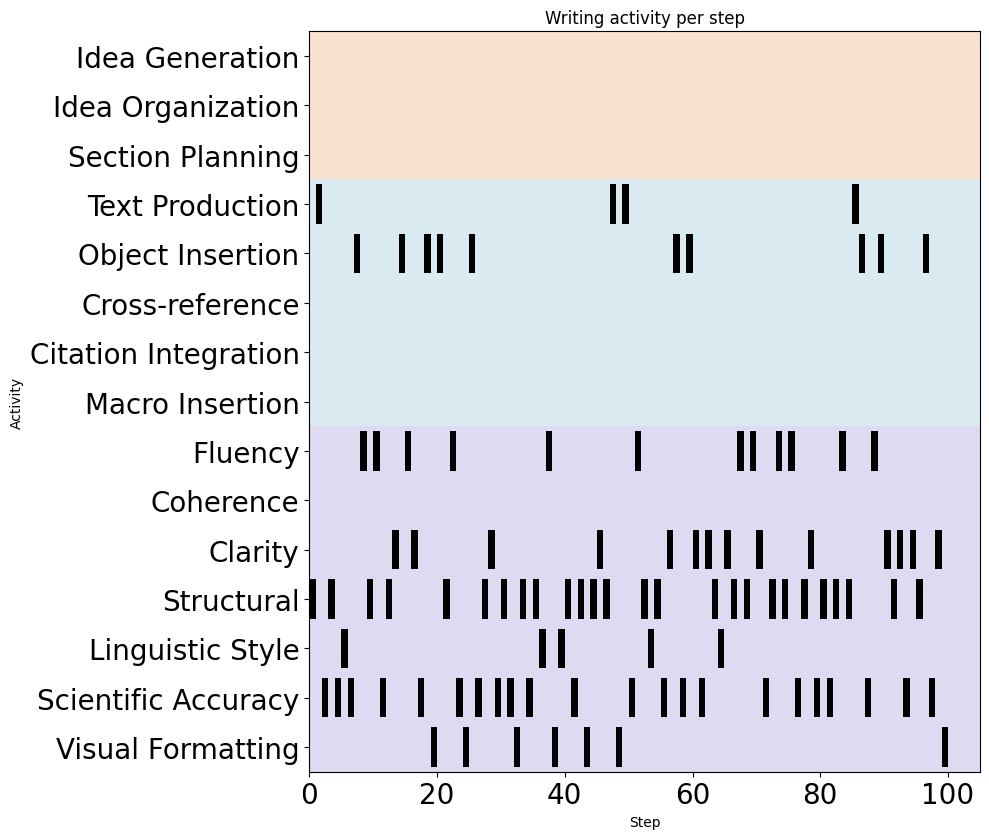

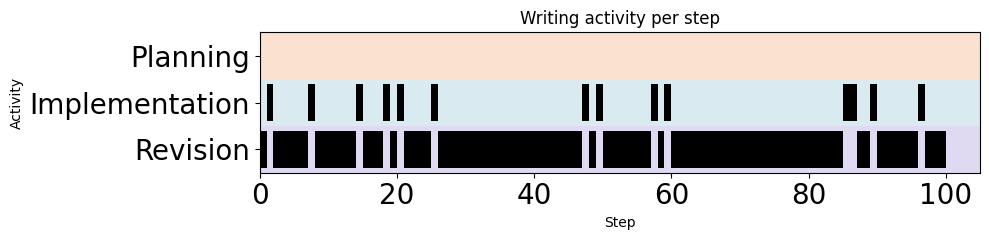

llama8_meta_output seed2


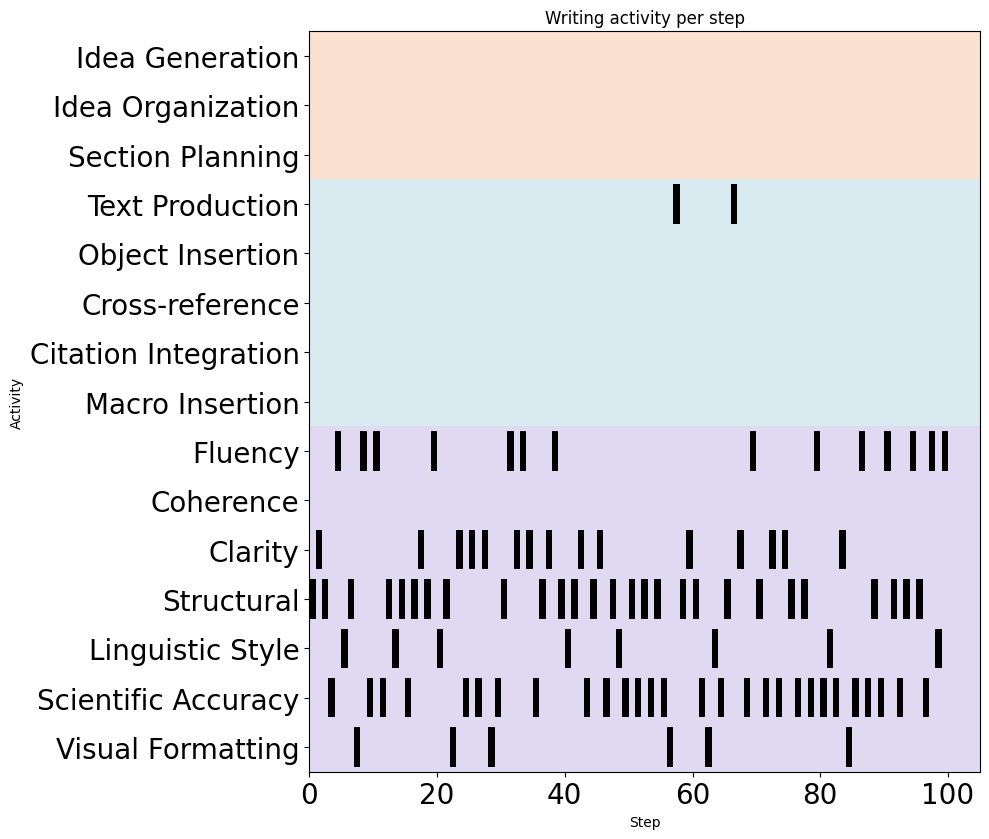

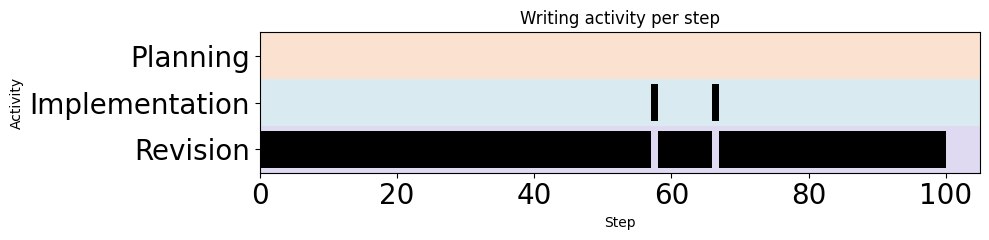

llama8_meta_output seed3


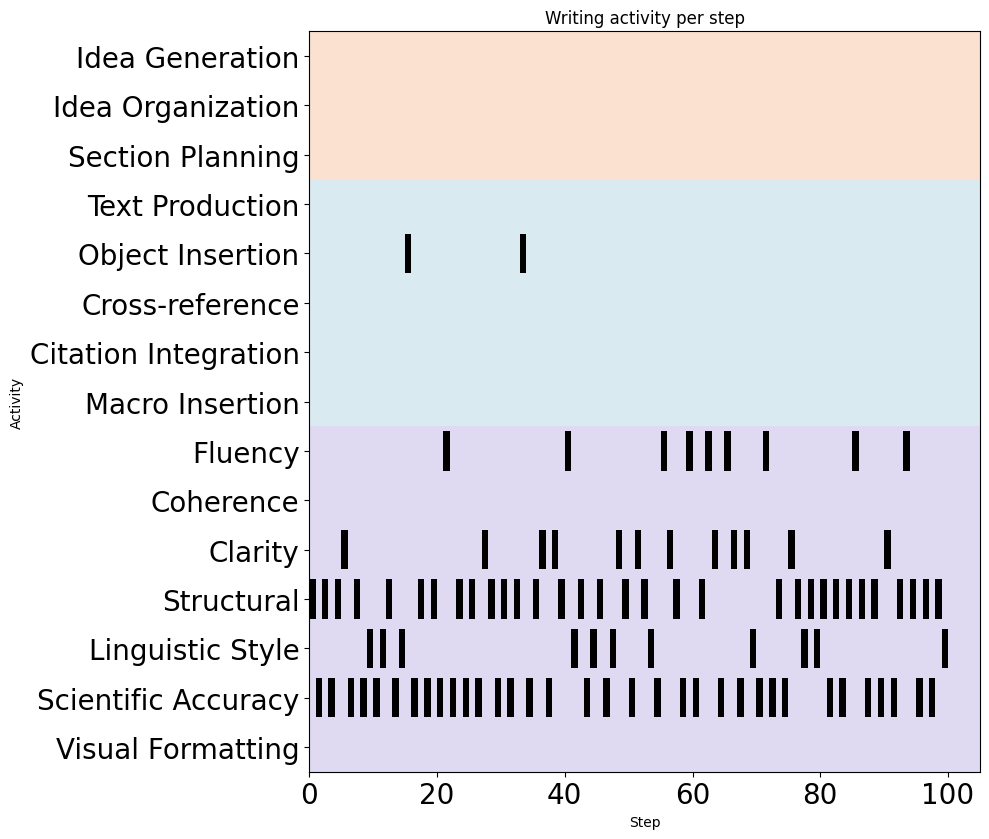

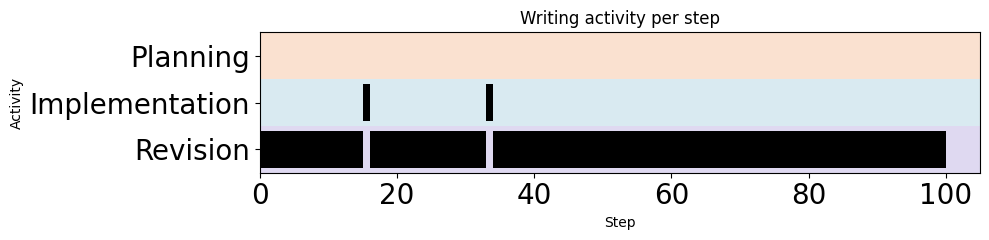

llama8_meta_output seed4


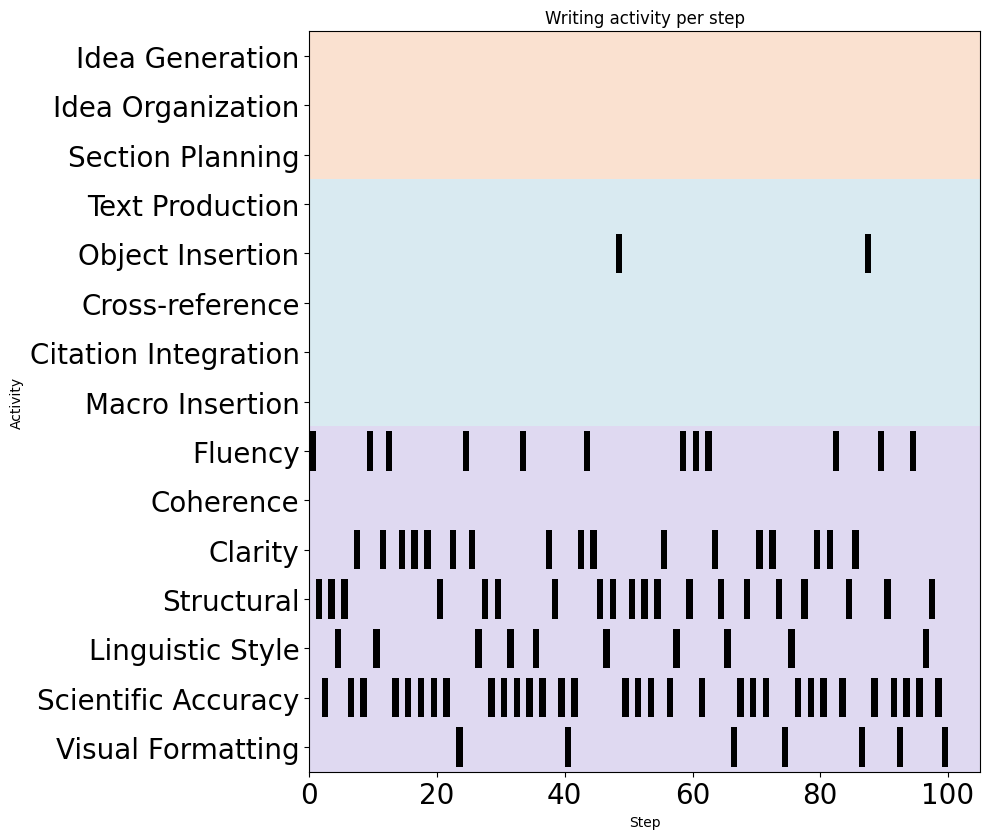

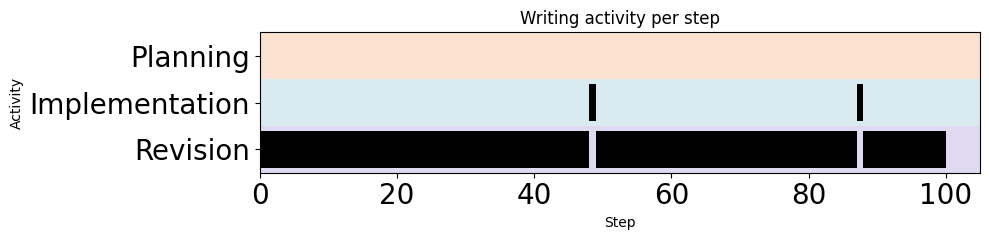

llama8_SW_output seed1


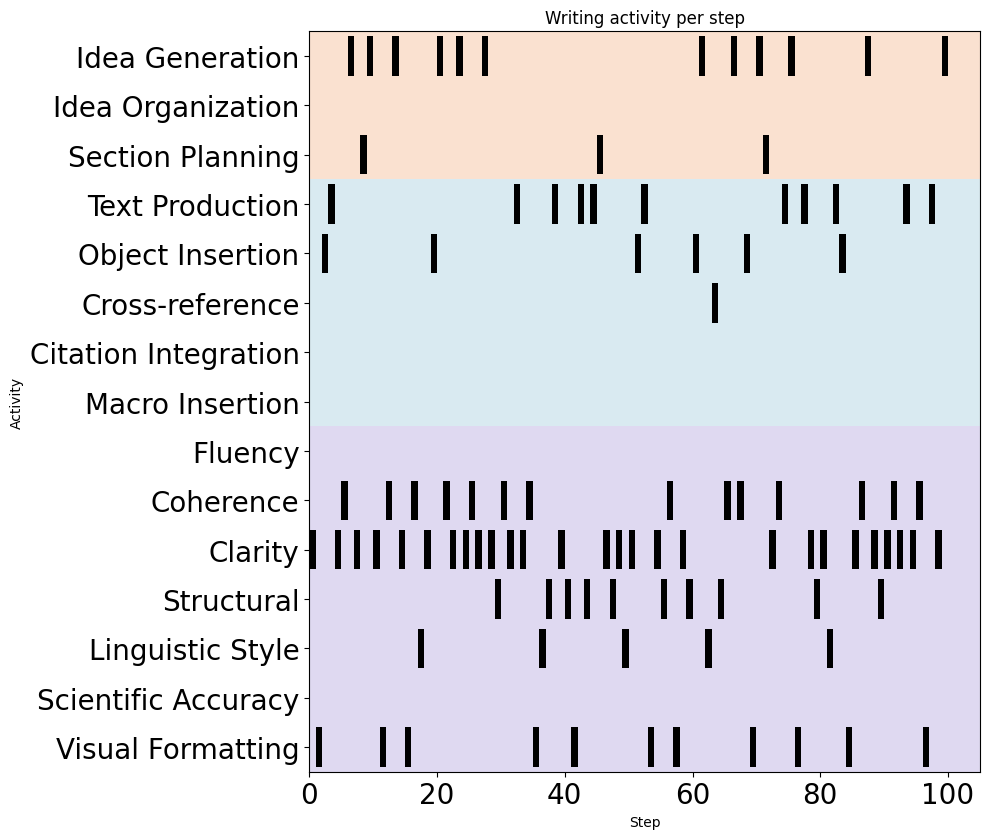

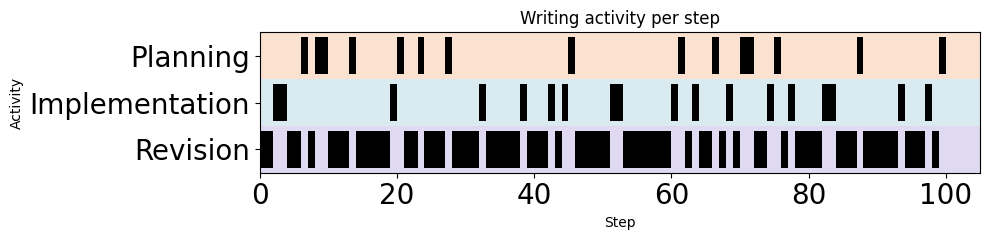

llama8_SW_output seed2


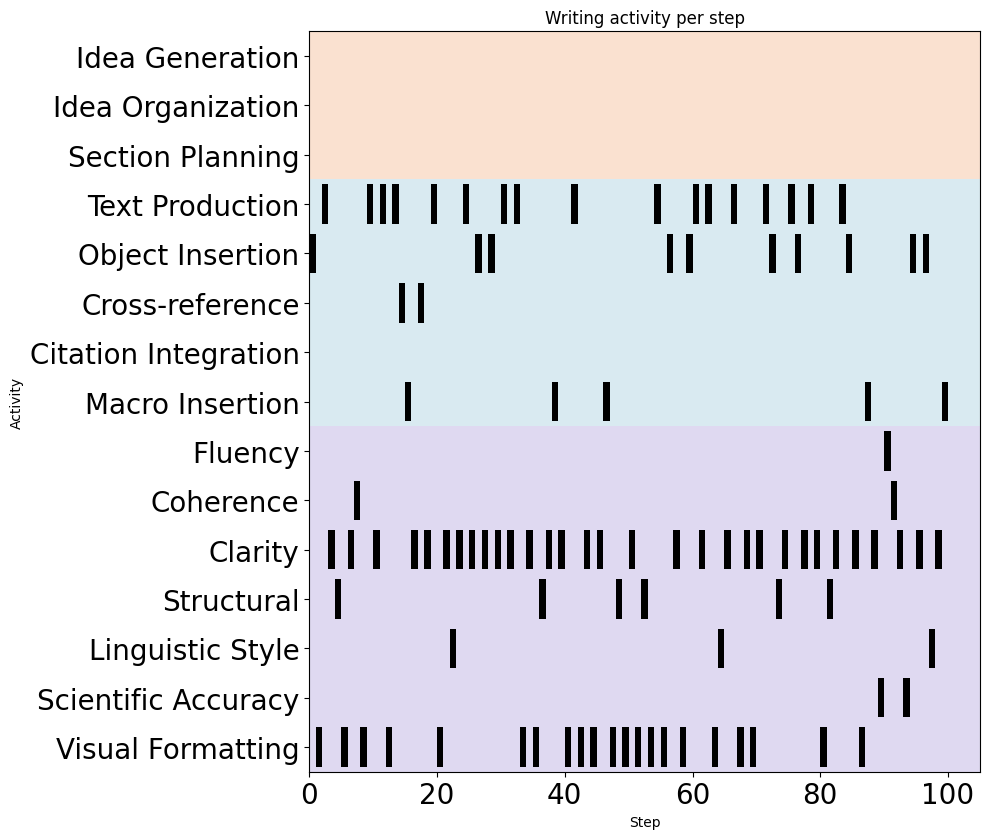

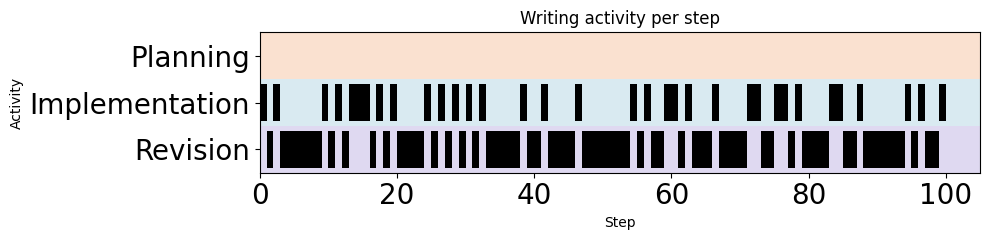

llama8_SW_output seed3


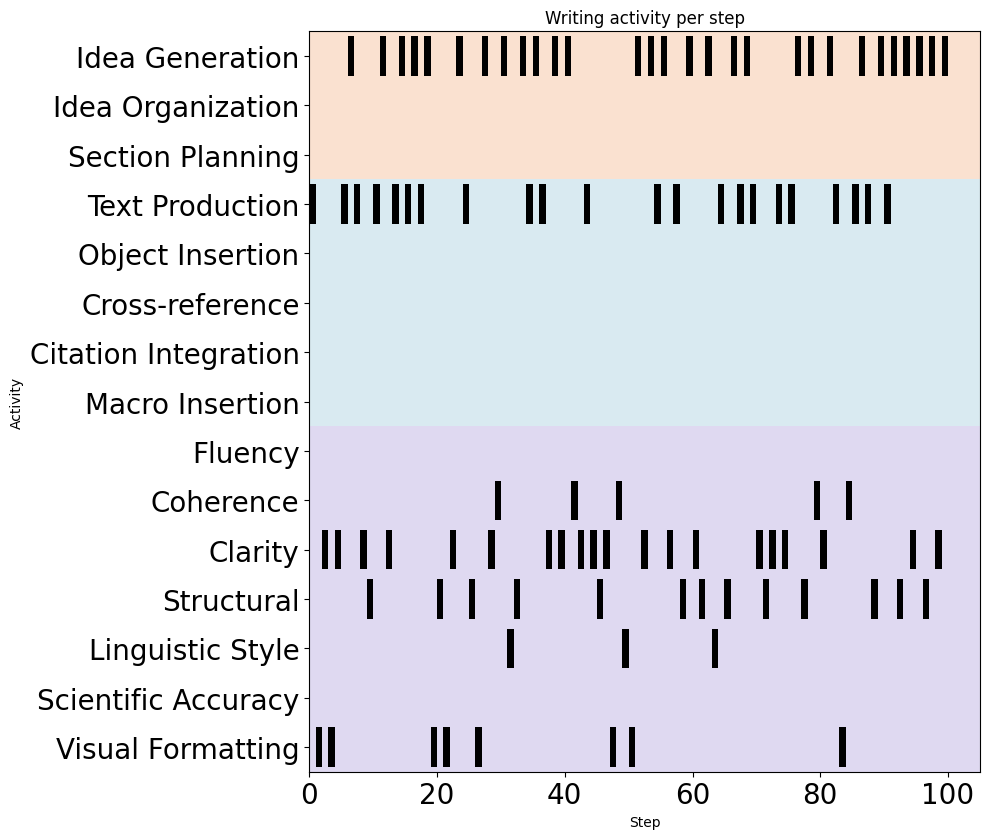

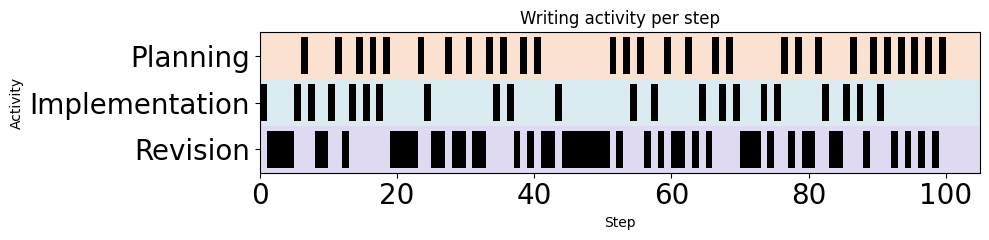

llama8_SW_output seed4


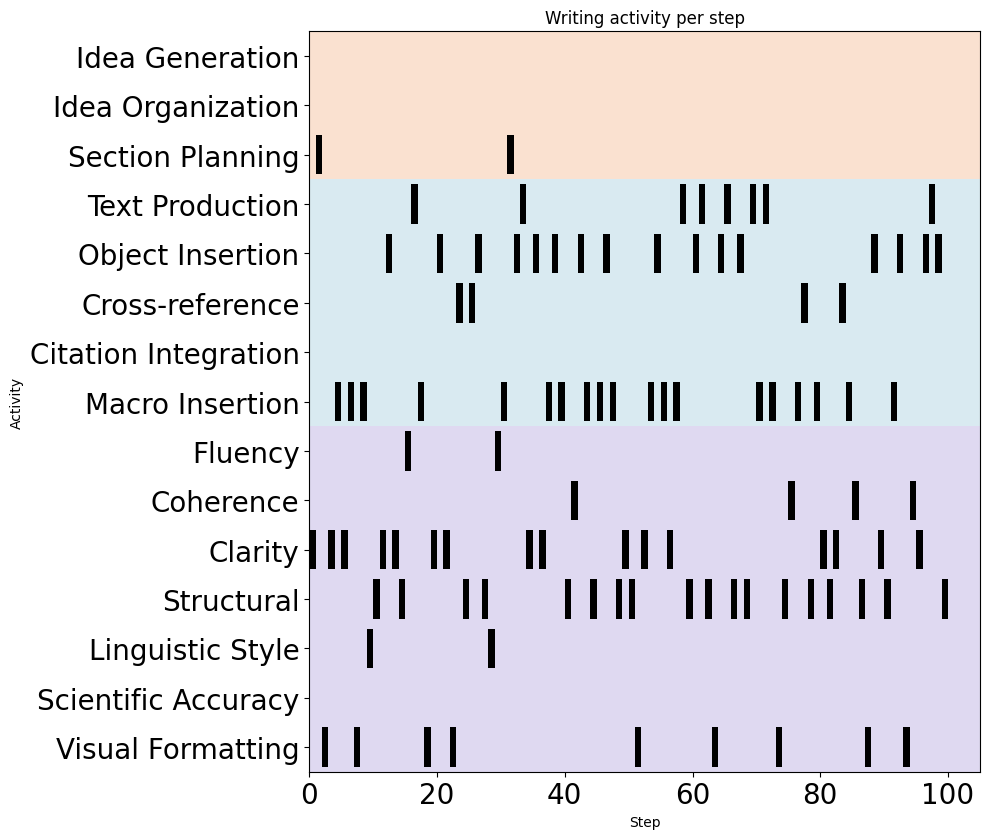

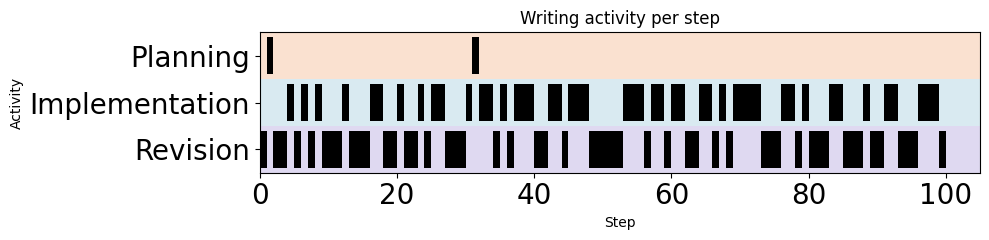

In [17]:
folders = ["gpt4o_output", "llama8_meta_output", "llama8_SW_output"]
seeds = ["seed1", "seed2", "seed3", "seed4"]
filenames = [f"iter_intention_{i}.txt" for i in range(100)]

for folder in folders:
    for seed in seeds:
        print(folder, seed)
        intentions = []
        for filename in filenames:
            intention_file = open(f"../outputs/{folder}/{seed}/intention/{filename}")
            intention = intention_file.read()
            intentions.append(intention)

        writing_activities_detailed(intentions)
        writing_activities_broad(intentions)
